# Le PIB est-il un indicateur robuste de l'accès à l'alimentation ?

In [20]:
pip install faostat

Note: you may need to restart the kernel to use updated packages.


In [21]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Partie 1 : Collecte des données

### Récupération des données de PIB à partir de la base de données de la banque mondiale

In [22]:
url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.KD?format=json&per_page=20000"


response = requests.get(url)

# Extraction du JSON de la réponse
PIB_hab = response.json()  # ici c’est correct

# Vérification des données
print(type(PIB_hab),len(PIB_hab))
print(PIB_hab[0]) # Métadonnées
print(PIB_hab[1][:5]) # Données de PIB par pays


<class 'list'> 2
{'page': 1, 'pages': 1, 'per_page': 20000, 'total': 17290, 'sourceid': '2', 'lastupdated': '2025-12-04'}
[{'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2024', 'value': 1416.25036869408, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2023', 'value': 1412.62538438423, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 US$)'}, 'country': {'id': 'ZH', 'value': 'Africa Eastern and Southern'}, 'countryiso3code': 'AFE', 'date': '2022', 'value': 1421.79716897878, 'unit': '', 'obs_status': '', 'decimal': 1}, {'indicator': {'id': 'NY.GDP.PCAP.KD', 'value': 'GDP per capita (constant 2015 

#Retraitement des données


Suppression des colonnes inutiles

In [23]:
donnees = PIB_hab[1]  # On ne garde pas les métadonnées

# On transforme le JSON en DataFrame et on ne garde que le PIB/hab pour chaque années avec le nom et le code du pays
liste_simplifiee = []
for item in donnees:
    nom_pays = item['country']['value']  # nom complet du pays
    annee = int(item['date'])
    pib = item['value']
    liste_simplifiee.append({'nom_pays': nom_pays, 'année': annee, 'PIB_par_habitant': pib})

PIB_hab_simple = pd.DataFrame(liste_simplifiee)

# Filtrer uniquement les années de 1960 à 2022. 
PIB_hab_simple = PIB_hab_simple[(PIB_hab_simple['année'] >= 2000) & (PIB_hab_simple['année'] <= 2024)]

# Afficher les 5 premières lignes
print(PIB_hab_simple.head(200))
PIB_hab_simple.loc[PIB_hab_simple['nom_pays'] == 'Russia']

                                        nom_pays  année  PIB_par_habitant
0                    Africa Eastern and Southern   2024       1416.250369
1                    Africa Eastern and Southern   2023       1412.625384
2                    Africa Eastern and Southern   2022       1421.797169
3                    Africa Eastern and Southern   2021       1409.040699
4                    Africa Eastern and Southern   2020       1383.724119
..                                           ...    ...               ...
475  East Asia & Pacific (excluding high income)   2004       2835.250834
476  East Asia & Pacific (excluding high income)   2003       2618.816094
477  East Asia & Pacific (excluding high income)   2002       2422.476717
478  East Asia & Pacific (excluding high income)   2001       2259.818286
479  East Asia & Pacific (excluding high income)   2000       2132.394104

[200 rows x 3 columns]


,nom_pays,année,PIB_par_habitant


Filtrage pour enlever les pays contenant des valeurs manquantes

In [24]:
#PIB_hab_simple_sans_NA = PIB_hab_simple.dropna()
#print(len(PIB_hab_simple['nom_pays'])/(2022-1960+1),len(PIB_hab_simple_sans_NA['nom_pays'])//(2022-1960+1)) # On a enlevé 48 pays ou groupe de pays de la liste

Restriction aux pays suivants : France, Etats-unis, Angleterre, Russie, Chine, Japon, Brésil, Afrique du Sud

In [25]:
# Liste des pays à conserver
pays_a_conserver = [
    'India', 'China', 'Brazil', 'South Africa', 'Russian Federation', 'Mexico'
]

# Filtrer le DataFrame
PIB_hab_BRICSAM = PIB_hab_simple[PIB_hab_simple['nom_pays'].isin(pays_a_conserver)]

# Vérifier le résultat
print(PIB_hab_BRICSAM['nom_pays'].unique())
print(PIB_hab_BRICSAM.head(126))

['Brazil' 'China' 'India' 'Mexico' 'Russian Federation' 'South Africa']
                 nom_pays  année  PIB_par_habitant
4875               Brazil   2024       9564.576077
4876               Brazil   2023       9288.027015
4877               Brazil   2022       9032.084816
4878               Brazil   2021       8799.229458
4879               Brazil   2020       8435.011433
...                   ...    ...               ...
13671  Russian Federation   2003       6370.453613
13672  Russian Federation   2002       5910.171875
13673  Russian Federation   2001       5618.955566
13674  Russian Federation   2000       5323.666504
14690        South Africa   2024       5708.964422

[126 rows x 3 columns]


Gestion des valeurs manquantes

In [26]:
for pays in PIB_hab_BRICSAM['nom_pays'].unique() :
    print(PIB_hab_BRICSAM.loc[PIB_hab_BRICSAM['nom_pays'] == pays].isna().sum(),pays)

nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 Brazil
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 China
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 India
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 Mexico
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 Russian Federation
nom_pays            0
année               0
PIB_par_habitant    0
dtype: int64 South Africa


### Récupération des données indicateurs alimentaires à partir de la base de données FAOSTAT

In [27]:
import faostat

df = faostat.list_datasets_df() # cette fonction permet de récupérer l'ensemble des indicateurs disponible
                                # ainsi que d'avoir des informations sur les màj de versions, etc
print(df)

   code                              label date_update     note_update  \
0   QCL       Crops and livestock products  2025-06-11  minor revision   
1    QI                 Production Indices  2025-02-03                   
2    QV   Value of Agricultural Production  2025-02-03                   
3    FS  Suite of Food Security Indicators  2025-07-28                   
4   FBS              Food Balances (2010-)  2025-10-28                   
..  ...                                ...         ...             ...   
63   FA           Food Aid Shipments (WFP)  2016-12-22                   
64   RM                          Machinery  2021-12-03  minor revision   
65   RY                  Machinery Archive  2021-12-03  minor revision   
66   RA                Fertilizers archive  2020-09-08  minor revision   
67   PA       Producer Prices (old series)  1991-12-31                   

            release_current state_current year_current release_next  \
0   2024-12-20 / 2025-06-11         fina

**On utilise la fonction définie dans le fichier py import des données faostat pour récupérer les données de 4 indicateurs  pour les pays des BRICSAM sur la période 2000 à 2022.**
**Les indicateurs sont :**
**"suffisance des apports énergétiques alimentaires moyens"**
**"disponibilité alimentaire par habitant"**
**"disponibilité protéiques moyenne"**
**"prévalence de la sous alimentation"**


In [28]:
from import_fao import get_datas_fao

In [29]:

liste_pays = [202,185,138,100,351,21] # Correspond aux codes des pays des BRICSAM
liste_indicateurs = ['21010','22000','21013'] # Correspond aux codes des indicateurs d'insécurité alimentaire
liste_années = [2000, 2022] # Correspond à la page de dates.

data_faostat = get_datas_fao(liste_pays, liste_indicateurs, liste_années)

print(data_faostat.head(10))



     Pays                                         Indicateur      Année Unité  \
0  Brazil  suffisance des apports énergétiques alimentair...  2000-2002     %   
1  Brazil  suffisance des apports énergétiques alimentair...  2001-2003     %   
2  Brazil  suffisance des apports énergétiques alimentair...  2002-2004     %   
3  Brazil  suffisance des apports énergétiques alimentair...  2003-2005     %   
4  Brazil  suffisance des apports énergétiques alimentair...  2004-2006     %   
5  Brazil  suffisance des apports énergétiques alimentair...  2005-2007     %   
6  Brazil  suffisance des apports énergétiques alimentair...  2006-2008     %   
7  Brazil  suffisance des apports énergétiques alimentair...  2007-2009     %   
8  Brazil  suffisance des apports énergétiques alimentair...  2008-2010     %   
9  Brazil  suffisance des apports énergétiques alimentair...  2009-2011     %   

   Valeur  
0   122.0  
1   124.0  
2   127.0  
3   129.0  
4   130.0  
5   131.0  
6   132.0  
7   133.0  


On vérifie ensuite qu'il n'y a pas de valeurs manquantes dans nos données. Comme ce n'est pas le cas, nous n'avons pas besoin de passer par un retraitement.

In [30]:
print(data_faostat.isna().sum())

Pays          0
Indicateur    0
Année         0
Unité         0
Valeur        0
dtype: int64


**Les indicateurs ont été moyennés sur 3 ans, et non par année. Nous avons des moyennes pour des périodes comme 2000-2002 et 2001-2003. Pour modéliser les données du PIB par habitant, nous avons décidé d'attribuer chaque moyenne triennale à la première année. Par exemple, la moyenne pour 2011-2013 correspond à 2011. Cela permet de maintenir la cohérence des tendances. Toutefois, si le PIB par habitant subit un choc au cours d'une année, le calcul de la moyenne peut atténuer ce choc sur les indicateurs alimentaires, ce qui affaiblit les résultats.**

In [31]:
from import_fao import format_annees

In [32]:
data_faostat = format_annees(data_faostat)


In [33]:
print(data_faostat['Unité'].unique())
print(data_faostat)

['%' 'kcal/cap/d' 'g/cap/d']
             Pays                                         Indicateur Année  \
0          Brazil  suffisance des apports énergétiques alimentair...  2000   
1          Brazil  suffisance des apports énergétiques alimentair...  2001   
2          Brazil  suffisance des apports énergétiques alimentair...  2002   
3          Brazil  suffisance des apports énergétiques alimentair...  2003   
4          Brazil  suffisance des apports énergétiques alimentair...  2004   
..            ...                                                ...   ...   
397  South Africa                   disponibilité protéiques moyenne  2016   
398  South Africa                   disponibilité protéiques moyenne  2017   
399  South Africa                   disponibilité protéiques moyenne  2018   
400  South Africa                   disponibilité protéiques moyenne  2019   
401  South Africa                   disponibilité protéiques moyenne  2020   

       Unité  Valeur  
0          

## Partie 2 : DATA VISUALIZATION

Evolutions des PIB/HAB

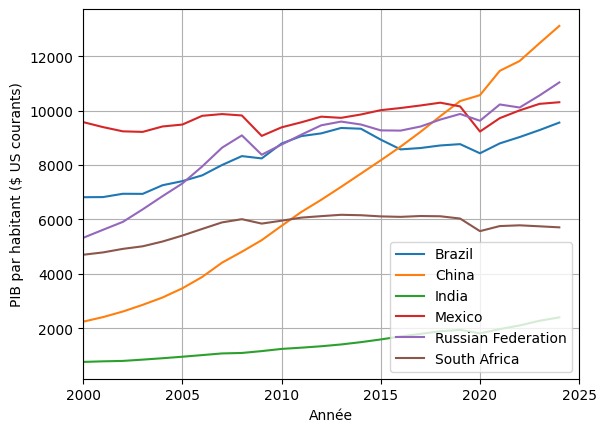

In [34]:
for pays in PIB_hab_BRICSAM['nom_pays'].unique() :
    PIB_hab_pays=PIB_hab_BRICSAM.loc[PIB_hab_BRICSAM['nom_pays'] == pays]
    plt.plot(PIB_hab_pays['année'],PIB_hab_pays['PIB_par_habitant'],label=pays)

plt.xlabel('Année')    
plt.ylabel('PIB par habitant ($ US courants)')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

Illustrations indicateurs

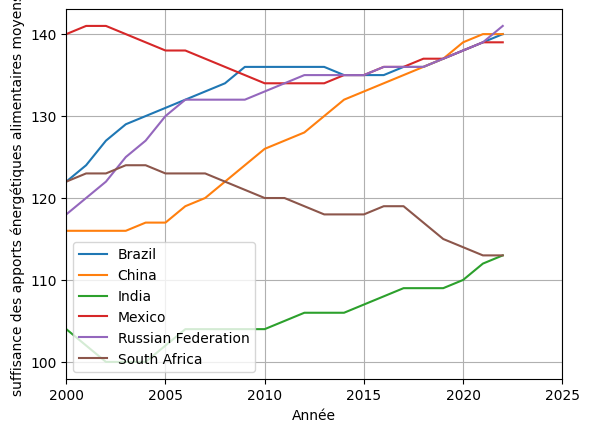

In [35]:
for pays in data_faostat['Pays'].unique() :
    data = data_faostat.loc[data_faostat['Indicateur']=='suffisance des apports énergétiques alimentaires moyens']
    data_pays = data.loc[data['Pays']==pays]
    plt.plot(data_pays['Année'],data_pays['Valeur'],label=pays)

plt.xlabel('Année')    
plt.ylabel('suffisance des apports énergétiques alimentaires moyens')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

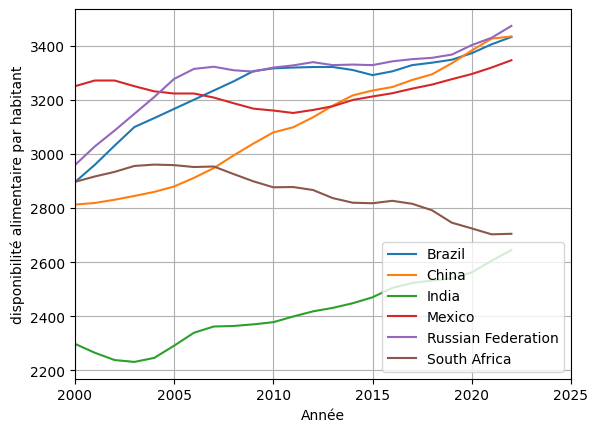

In [36]:
for pays in data_faostat['Pays'].unique() :
    data = data_faostat.loc[data_faostat['Indicateur']=='disponibilité alimentaire par habitant']
    data_pays = data.loc[data['Pays']==pays]
    plt.plot(data_pays['Année'],data_pays['Valeur'],label=pays)

plt.xlabel('Année')    
plt.ylabel('disponibilité alimentaire par habitant')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

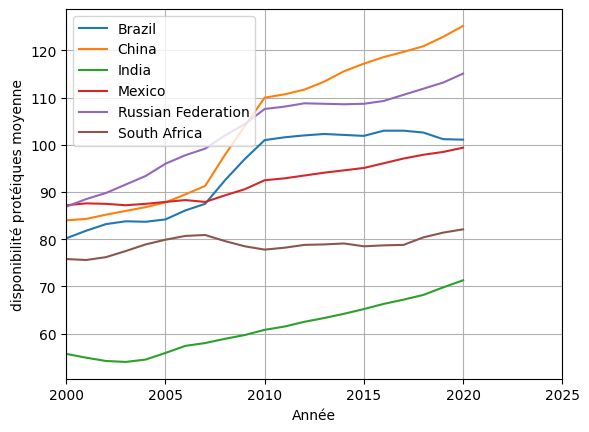

In [37]:
for pays in data_faostat['Pays'].unique() :
    data = data_faostat.loc[data_faostat['Indicateur']=='disponibilité protéiques moyenne']
    data_pays = data.loc[data['Pays']==pays]
    plt.plot(data_pays['Année'],data_pays['Valeur'],label=pays)

plt.xlabel('Année')    
plt.ylabel('disponibilité protéiques moyenne')
plt.grid()
plt.legend()
plt.xlim(left=2000, right=2025)
plt.show()

## Partie 3 : MODELE

### ACP

### Régression(s) linéaire PIB/hab

### Régression(s) linéaire IDH